# Distance solver

In [383]:
def get_xz_from_uv(bbox):
    # ref : http://ksimek.github.io/2013/08/13/intrinsic/
    car_width = 2.0  # assume car width is always 2.0m...
    fx = 714.1526
    fy = 710.3725
    cx = 713.85
    cy = 327

    # distance calc ref: http://emaraic.com/blog/distance-measurement
    # Forwards/backwards
    z_distance = fx * (car_width / (bbox['right'] - bbox['left']))

    # find the approximate centre of the car ref:
    bb_c = (bbox['right'] + bbox['left'])/2

    # calculate the approx world x location from the pixel u
    # ref slide 10 of: http://www.cse.psu.edu/~rtc12/CSE486/lecture12.pdf
    approx_x = (bb_c - cx )*z_distance/fx

    approx_x+=0.053439859801385325*z_distance-0.5385462033846319 #testing least-square adjustment, y distance
    z_distance+=0.6055511973113685*approx_x + 2.2209803015779133 #testing least-square adjustment, x distance
    approx_x+=0.0026834076878362386*(bbox['right'] + bbox['left'])/2 + -1.899805878278793

    return approx_x,z_distance

# IOU

In [384]:
def iou(bb1, bb2):
    x_left = max(bb1['left'], bb2['left'])
    y_top = min(bb1['top'], bb2['top'])
    x_right = min(bb1['right'], bb2['right'])
    y_bottom = max(bb1['bottom'], bb2['bottom'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['right'] - bb1['left']) * (bb1['bottom'] - bb1['top'])
    bb2_area = (bb2['right'] - bb2['left']) * (bb2['bottom'] - bb2['top'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou
 
def area(bb):
    x = bb['right']-bb['left']
    y = bb['bottom']-bb['top']
    return x*y
 
def overlap(bb1, bb2):
    if bb1["right"] < bb2["left"] or bb1["left"] > bb2["right"]:
        if bb1["bottom"] < bb2["top"] or bb1["top"] > bb2["bottom"]:
            return False  
    return True

In [664]:
import uuid
import numpy as np
import math

def rectCenter(bbox):
    x = bbox['right']+bbox['left']
    y = bbox['bottom']+bbox['top']
    return (x/2,y/2)

def findBiggestMatch(targetF1, bboxesF2):
    matchingBboxIndex = -1
    biggestMatch = 0
    for i, currBbox in enumerate(bboxesF2):
        iouVal = IOU(targetF1, currBbox)
        if (iouVal > biggestMatch):
            biggestMatch = iouVal
            matchingBboxIndex = i
    
    if biggestMatch == 0:
#         print ("*** No match found between frames ***")
        pass
    
    return (matchingBboxIndex, biggestMatch)

def findNearestMatch(targetF1, bboxesF2, requireOverlap=True):
    matchingBboxIndex = -1
    nearestMatch = 1000
    targetWidth = targetF1["right"]-targetF1['left']
    for i, currBbox in enumerate(bboxesF2):
        if requireOverlap and not overlap(targetF1, currBbox):
            continue
        x1,y1 = rectCenter(targetF1)
        x2,y2 = rectCenter(currBbox)
        dist = math.sqrt((x1-x2)**2+(y1-y2)**2)
        if (dist < nearestMatch):
            nearestMatch = dist
            matchingBboxIndex = i
    
    return (matchingBboxIndex, nearestMatch)

def prepareStructure(inputStructure):
    for frame in inputStructure:
        for bbox in inputStructure[frame]:
            bbox["boxMatched"] = False
            bbox["colour"] = np.random.rand(3,)
            bbox["id"]=uuid.uuid1()
        
        i = 0
        while i < len(inputStructure[frame]):
            j = i+1
            while j < len(inputStructure[frame]):
                if (iou(inputStructure[frame][i], inputStructure[frame][j]) > 0.9):
                    inputStructure[frame].pop(j)
                    j-=1
                
                j+=1
            
            i+=1
    

def matchBboxes(inputStructure, maxNumFrameGaps = 3, boxesMustOverlap=True):
    frameI = 0
    while (frameI < len(inputStructure)):
#         print("new main frame")
        frameSkipI = 1
        while (frameSkipI <= maxNumFrameGaps and (frameI+frameSkipI) < len(inputStructure)):
#             print("\tnew sub frame")
            for currBbox in inputStructure[f"{frameI+1}"]:
#                 if (area(currBbox)>5000):
#                     print("\t\tAHHH")
#                     print(f"\t\t{currBbox}")
#                 matchIndexb, matchValue = findBiggestMatch(currBbox, inputStructure[f"{frameI+frameSkipI+1}"])
                matchIndex, matchValue = findNearestMatch(currBbox, inputStructure[f"{frameI+frameSkipI+1}"], boxesMustOverlap)
                
#                 if matchIndexb != matchIndex:
#                     print("NOOOO")
                if (matchIndex != -1 and inputStructure[f"{frameI+frameSkipI+1}"][matchIndex]["boxMatched"] == False):
                    
                    inputStructure[f"{frameI+frameSkipI+1}"][matchIndex]["boxMatched"] == True
                    inputStructure[f"{frameI+frameSkipI+1}"][matchIndex]["id"] = currBbox["id"]
                    inputStructure[f"{frameI+frameSkipI+1}"][matchIndex]["colour"] = currBbox["colour"]
            frameSkipI+=1
        
        frameI+=1

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
        
def findVelocitiesRegression(inputStructure, getLastNPoints=0, showGraphs=False):
    output = {}
    
    # Get full ID list
    for frame in inputStructure:
        for bbox in inputStructure[frame]:
            if bbox["id"] not in output:
                output[bbox["id"]] = {"bboxes":[None for i in range(40)], "distances":[(-1,-1) for i in range(40)]}
            output[bbox["id"]]["bboxes"][int(frame)-1] = bbox
            output[bbox["id"]]["distances"][int(frame)-1] = get_xz_from_uv(bbox)
    
    
    numPointsCutoff = 3
    for bboxID in output:
        frameTimeGap = 0.05
        
        
        zDistance = []
        xDistance = []
        time = []
        currTime = 0
        for z, x in output[bboxID]["distances"]:
            if x != -1 and z != -1:
                zDistance.append(z)
                xDistance.append(x)
                time.append(currTime)
            currTime += frameTimeGap
        
        if len(time) < numPointsCutoff:
            continue
            
        zDistanceLim = np.array(zDistance[-getLastNPoints:])
        xDistanceLim = np.array(xDistance[-getLastNPoints:])
        timeLim = np.array(time[-getLastNPoints:])
        A = np.vstack([timeLim, np.ones(len(timeLim))]).T
        
        mZ, cZ = np.linalg.lstsq(A, zDistanceLim, rcond=None)[0]
        mX, cX = np.linalg.lstsq(A, xDistanceLim, rcond=None)[0]
        
        if showGraphs:
            plt.figure(figsize=(20, 5))
            plt.subplot(121),plt.plot(time, zDistance, 'o', label='Original points', markersize=10)
            plt.plot(timeLim, zDistanceLim, 'o', label=f'{getLastNPoints} Regression points', markersize=10)
            plt.plot(timeLim, mZ*timeLim + cZ, 'r', label='Fitted line')
            plt.title(f"z distance Velocity Calculation: v={mZ}m\s")
            plt.legend()
            plt.subplot(122),plt.plot(time, xDistance, 'o', label='Original points', markersize=10)
            plt.plot(timeLim, xDistanceLim, 'o', label=f'{getLastNPoints} Regression points', markersize=10)
            plt.plot(timeLim, mX*timeLim + cX, 'r', label='Fitted line')
            plt.title(f"x distance Velocity Calculation: v={mX}m\s")
            plt.legend()
            plt.show()
        
        output[bboxID]["velocity"] = (mZ, mX)
        
    return output
            
            
def matchGT(gtData, inputStructure, matchedBBoxes, showGraph=False):
    result = []
    for gtBbox in gtData:
        matchIndex, matchValue = findNearestMatch(gtBbox["bbox"], matchedBBoxes["40"], True)
        if (matchIndex == -1):
            print("Error: No matching BBox found")
            continue
        currID = matchedBBoxes["40"][matchIndex]["id"]
        predVel = inputStructure[currID]["velocity"]
        gtVel = gtBbox["velocity"]
#         print(f"Z = {predVel[0]}:{gtVel[0]}, X={predVel[1]}:{gtVel[1]}")
#         print(f"\tAbs err z: {abs(gtVel[0]-predVel[0])}")
#         print(f"\tAbs err x: {abs(gtVel[1]-predVel[1])}")
        result.append(((predVel[0],gtVel[0]),(predVel[1],gtVel[1])))
    
        if showGraph:
            frameTimeGap = 0.05
            zDistance = []
            xDistance = []
            time = []
            currTime = 0
            for z, x in inputStructure[currID]["distances"]:
                if x != -1 and z != -1:
                    zDistance.append(z)
                    xDistance.append(x)
                    time.append(currTime)
                currTime += frameTimeGap


            zDistanceLim = np.array(zDistance[-40:])
            xDistanceLim = np.array(xDistance[-40:])
            timeLim = np.array(time[-40:])
            A = np.vstack([timeLim, np.ones(len(timeLim))]).T

            mZ, cZ = np.linalg.lstsq(A, zDistanceLim, rcond=None)[0]
            mX, cX = np.linalg.lstsq(A, xDistanceLim, rcond=None)[0]

            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            plt.plot(timeLim, zDistanceLim, 'o', label=f'Regression points', markersize=10)
            plt.plot(timeLim, mZ*timeLim + cZ, 'r', label='Estimated Velocity (Fitted)')
            plt.plot(timeLim, gtVel[0]*timeLim + (mZ + cZ-gtVel[0]), label='Ground Truth Velocity')
            plt.ylabel("Distance (m)")
            plt.xlabel("Time (s)")
            plt.title(f"z distance Velocity Calculation: v={round(mZ,4)}m\s")
            plt.legend()
            plt.subplot(122)
            plt.plot(timeLim, xDistanceLim, 'o', label=f'Regression points', markersize=10)
            plt.plot(timeLim, mX*timeLim + cX, 'r', label='Estimated Velocity (Fitted)')
            plt.plot(timeLim, gtVel[1]*timeLim + (mX + cX-gtVel[1]),  label='Ground Truth Velocity')
            plt.ylabel("Distance (m)")
            plt.xlabel("Time (s)")
            plt.title(f"x distance Velocity Calculation: v={round(mX,4)}m\s")
            plt.legend()
            plt.show()
            
            

    return result

# Test Input

In [614]:
xx = {"1": [{"left": 526.00032, "top": 356.999832, "right": 544.00032, "bottom": 367.999848}, {"left": 506.00064, "top": 358.00023600000003, "right": 522.00064, "bottom": 368.000244}, {"left": 673.000512, "top": 351.00007200000005, "right": 720.0004479999999, "bottom": 389.000088}, {"left": 727.99936, "top": 316.000008, "right": 763.99936, "bottom": 367.999992}, {"left": 931.99936, "top": 330.00012000000004, "right": 1279.99936, "bottom": 560.99988}, {"left": 346.000128, "top": 363.00023999999996, "right": 385.00019199999997, "bottom": 381.00023999999996}], "2": [{"left": 500.99968, "top": 358.00023600000003, "right": 516.99968, "bottom": 368.000244}, {"left": 522.00032, "top": 358.00023600000003, "right": 540.00032, "bottom": 368.000244}, {"left": 335.00032, "top": 361.99990799999995, "right": 375.00032, "bottom": 382.999932}, {"left": 674.0001920000001, "top": 350.99974800000007, "right": 721.000128, "bottom": 389.999772}, {"left": 932.9996799999999, "top": 327.99996000000004, "right": 1280.0, "bottom": 569.9998800000001}, {"left": 727.99936, "top": 316.000008, "right": 763.99936, "bottom": 367.999992}], "3": [{"left": 590.0, "top": 356.00032080000005, "right": 602.0, "bottom": 363.00031920000004}, {"left": 496.00044800000006, "top": 357.999912, "right": 513.0005120000001, "bottom": 368.99992799999995}, {"left": 515.99936, "top": 358.00030799999996, "right": 535.99936, "bottom": 370.000332}, {"left": 321.9998719999999, "top": 364.999752, "right": 362.999808, "bottom": 384.99976799999996}, {"left": 676.00032, "top": 351.99975600000005, "right": 722.00032, "bottom": 388.999764}, {"left": 934.9996799999999, "top": 328.99967999999996, "right": 1279.9993599999998, "bottom": 564.99984}, {"left": 727.99936, "top": 318.99967200000003, "right": 763.99936, "bottom": 365.999688}], "4": [{"left": 587.000192, "top": 354.999924, "right": 600.0001279999999, "bottom": 362.99991600000004}, {"left": 490.99936, "top": 358.99992, "right": 504.99936, "bottom": 367.99992}, {"left": 511.99968, "top": 357.000228, "right": 529.99968, "bottom": 369.00025200000005}, {"left": 309.00032, "top": 364.999752, "right": 353.00032, "bottom": 384.99976799999996}, {"left": 674.9998720000001, "top": 349.99999199999996, "right": 721.999808, "bottom": 388.0000079999999}, {"left": 937.0003199999999, "top": 329.0004, "right": 1280.00064, "bottom": 570.0002400000001}, {"left": 730.0, "top": 316.000008, "right": 766.0, "bottom": 367.999992}], "5": [{"left": 583.9998720000001, "top": 354.999924, "right": 596.999808, "bottom": 362.99991600000004}, {"left": 487.00032, "top": 357.999912, "right": 503.00032, "bottom": 368.99992799999995}, {"left": 506.99968, "top": 358.00030799999996, "right": 526.99968, "bottom": 370.000332}, {"left": 294.99935999999997, "top": 364.000176, "right": 340.99935999999997, "bottom": 387.000144}, {"left": 676.00032, "top": 350.999676, "right": 722.00032, "bottom": 387.999684}, {"left": 730.0, "top": 316.000008, "right": 766.0, "bottom": 367.999992}, {"left": 939.0003200000001, "top": 327.99996, "right": 1280.0, "bottom": 576.99972}], "6": [{"left": 582.0005120000001, "top": 353.999844, "right": 595.000448, "bottom": 361.999836}, {"left": 500.99955199999994, "top": 357.000228, "right": 521.9994879999999, "bottom": 369.00025200000005}, {"left": 482.00032, "top": 357.999912, "right": 500.00032, "bottom": 368.99992799999995}, {"left": 279.00051199999996, "top": 364.000176, "right": 330.000448, "bottom": 387.000144}, {"left": 676.00032, "top": 350.000316, "right": 722.00032, "bottom": 387.000324}, {"left": 732.00064, "top": 314.000172, "right": 768.00064, "bottom": 365.00014799999997}, {"left": 942.0006400000001, "top": 327.99996, "right": 1280.0, "bottom": 583.0002}], "7": [{"left": 579.99936, "top": 353.999844, "right": 591.99936, "bottom": 361.999836}, {"left": 476.99936, "top": 357.999912, "right": 494.99936, "bottom": 368.99992799999995}, {"left": 496.00032, "top": 357.000228, "right": 518.00032, "bottom": 369.00025200000005}, {"left": 263.99936, "top": 365.000256, "right": 315.99936, "bottom": 388.00022399999995}, {"left": 732.9994879999999, "top": 311.000076, "right": 769.999552, "bottom": 366.00008399999996}, {"left": 677.99968, "top": 349.99999199999996, "right": 723.99968, "bottom": 388.0000079999999}, {"left": 945.9993600000001, "top": 330.00048, "right": 1280.0, "bottom": 578.0001599999999}], "8": [{"left": 576.9995520000001, "top": 353.999844, "right": 589.999488, "bottom": 361.999836}, {"left": 489.99967999999996, "top": 356.99990399999996, "right": 511.99967999999996, "bottom": 369.999936}, {"left": 471.00019199999997, "top": 357.000228, "right": 492.000128, "bottom": 369.00025200000005}, {"left": 245.00044799999998, "top": 366.00001199999997, "right": 300.00051199999996, "bottom": 389.99998800000003}, {"left": 733.0, "top": 309.999672, "right": 771.0, "bottom": 365.99968799999994}, {"left": 948.00064, "top": 329.00003999999996, "right": 1280.00064, "bottom": 582.0001199999999}, {"left": 677.99968, "top": 348.999912, "right": 723.99968, "bottom": 386.99992799999995}], "9": [{"left": 573.99968, "top": 353.999844, "right": 587.99968, "bottom": 361.999836}, {"left": 465.00012799999996, "top": 358.00023600000003, "right": 482.0001919999999, "bottom": 368.000244}, {"left": 484.99955199999994, "top": 356.99990399999996, "right": 505.999488, "bottom": 369.999936}, {"left": 950.9996800000001, "top": 330.00048, "right": 1279.99936, "bottom": 587.00016}, {"left": 228.00051200000004, "top": 366.000084, "right": 285.00044800000006, "bottom": 392.00007600000004}, {"left": 733.0, "top": 310.99967999999996, "right": 771.0, "bottom": 364.99967999999996}, {"left": 677.9993599999999, "top": 349.00023600000003, "right": 725.9993599999999, "bottom": 386.000244}], "10": [{"left": 570.0, "top": 353.00016, "right": 582.0, "bottom": 362.00016}, {"left": 459.00064000000003, "top": 356.99990399999996, "right": 481.00064000000003, "bottom": 369.999936}, {"left": 476.99968, "top": 357.999984, "right": 500.99968, "bottom": 371.000016}, {"left": 953.9999999999999, "top": 327.9996, "right": 1279.9993599999998, "bottom": 599.99976}, {"left": 207.99936, "top": 366.99984000000006, "right": 267.99936, "bottom": 393.99984000000006}, {"left": 733.9996800000001, "top": 310.99967999999996, "right": 771.9996800000001, "bottom": 364.99967999999996}, {"left": 680.00032, "top": 348.999912, "right": 726.00032, "bottom": 386.99992799999995}], "11": [{"left": 453.000512, "top": 358.00030799999996, "right": 476.00044800000006, "bottom": 370.000332}, {"left": 470.00032, "top": 357.999984, "right": 496.00032, "bottom": 371.000016}, {"left": 957.9999999999999, "top": 330.00012000000004, "right": 1280.0006399999997, "bottom": 601.0002}, {"left": 183.99967999999998, "top": 367.999992, "right": 249.99967999999998, "bottom": 397.000008}, {"left": 733.9996800000001, "top": 311.99976, "right": 771.9996800000001, "bottom": 365.99976}, {"left": 679.9995520000001, "top": 349.99992, "right": 726.999488, "bottom": 385.99992}], "12": [{"left": 561.99936, "top": 354.00024, "right": 577.99936, "bottom": 363.00024}, {"left": 465.99936, "top": 357.999984, "right": 489.99936, "bottom": 371.000016}, {"left": 445.99968, "top": 357.999984, "right": 467.99968, "bottom": 371.000016}, {"left": 158.000192, "top": 368.99974799999995, "right": 229.000128, "bottom": 398.999772}, {"left": 962.0000000000001, "top": 329.9997599999999, "right": 1279.99936, "bottom": 601.99992}, {"left": 680.0, "top": 348.999912, "right": 728.0, "bottom": 386.99992799999995}, {"left": 736.00064, "top": 314.000172, "right": 772.00064, "bottom": 365.00014799999997}], "13": [{"left": 560.00032, "top": 352.999836, "right": 574.00032, "bottom": 362.999844}, {"left": 455.99968, "top": 359.00006399999995, "right": 481.99968, "bottom": 372.000096}, {"left": 440.00032, "top": 359.00006399999995, "right": 462.00032, "bottom": 372.000096}, {"left": 128.0, "top": 369.999936, "right": 208.0, "bottom": 401.99990399999996}, {"left": 966.0006400000001, "top": 329.9997599999999, "right": 1280.0, "bottom": 601.99992}, {"left": 681.000512, "top": 348.999912, "right": 728.0004479999999, "bottom": 386.99992799999995}, {"left": 736.0003200000001, "top": 314.000172, "right": 774.0003200000001, "bottom": 365.00014799999997}], "14": [{"left": 556.00032, "top": 353.99991600000004, "right": 570.00032, "bottom": 363.999924}, {"left": 432.00032, "top": 360.00014400000003, "right": 454.00032, "bottom": 373.00017600000007}, {"left": 448.999808, "top": 359.0001720000001, "right": 475.9998719999999, "bottom": 374.000148}, {"left": 969.9993599999999, "top": 329.99976000000004, "right": 1280.0, "bottom": 604.00008}, {"left": 682.0001920000001, "top": 349.99999199999996, "right": 729.000128, "bottom": 388.0000079999999}, {"left": 95.00031999999999, "top": 371.999844, "right": 183.00032, "bottom": 406.999836}, {"left": 736.0003200000001, "top": 313.999848, "right": 774.0003200000001, "bottom": 365.999832}], "15": [{"left": 551.999488, "top": 353.99991600000004, "right": 566.9995520000001, "bottom": 363.999924}, {"left": 423.99955199999994, "top": 358.99977600000005, "right": 446.999488, "bottom": 372.999744}, {"left": 439.00012799999996, "top": 359.0001720000001, "right": 468.0001919999999, "bottom": 374.000148}, {"left": 974.0, "top": 330.99984000000006, "right": 1278.99968, "bottom": 603.0}, {"left": 60.0, "top": 375.00001199999997, "right": 152.0, "bottom": 407.9999879999999}, {"left": 681.99936, "top": 347.999832, "right": 729.99936, "bottom": 385.999848}, {"left": 737.0004479999999, "top": 313.000092, "right": 776.000512, "bottom": 364.00006799999994}], "16": [{"left": 548.0, "top": 353.99991600000004, "right": 564.0, "bottom": 363.999924}, {"left": 416.00032, "top": 359.999856, "right": 438.00032, "bottom": 373.999824}, {"left": 430.99936, "top": 360.00025200000005, "right": 460.99936, "bottom": 375.000228}, {"left": 981.99936, "top": 325.99979999999994, "right": 1277.99936, "bottom": 619.99956}, {"left": 738.000128, "top": 313.000092, "right": 777.0001920000001, "bottom": 364.00006799999994}, {"left": 681.99936, "top": 348.000228, "right": 729.99936, "bottom": 387.00025200000005}, {"left": 14.000064000000002, "top": 379.00033199999996, "right": 121.0, "bottom": 412.000308}], "17": [{"left": 544.0, "top": 353.99991600000004, "right": 560.0, "bottom": 363.999924}, {"left": 407.00032000000004, "top": 359.999856, "right": 431.00032000000004, "bottom": 373.999824}, {"left": 421.99968, "top": 359.99992799999995, "right": 451.99968, "bottom": 375.999912}, {"left": 739.0006400000001, "top": 306.00025200000005, "right": 777.0006400000001, "bottom": 366.000228}, {"left": 1.9999359999999982, "top": 379.999908, "right": 87.99993599999999, "bottom": 418.99993200000006}, {"left": 985.00032, "top": 325.9998, "right": 1278.99968, "bottom": 623.9998800000001}, {"left": 683.0003199999999, "top": 347.999832, "right": 731.0003199999999, "bottom": 385.999848}], "18": [{"left": 538.9994879999999, "top": 353.99991600000004, "right": 555.999552, "bottom": 363.999924}, {"left": 397.999872, "top": 360.00025200000005, "right": 422.99980800000003, "bottom": 375.000228}, {"left": 1.0000640000000018, "top": 379.00008, "right": 46.0, "bottom": 424.00008}, {"left": 413.000512, "top": 359.99992799999995, "right": 444.00044800000006, "bottom": 375.999912}, {"left": 740.00032, "top": 306.999828, "right": 778.00032, "bottom": 363.99985200000003}, {"left": 988.00064, "top": 326.99988, "right": 1280.00064, "bottom": 622.9998}, {"left": 683.999552, "top": 346.99975200000006, "right": 730.9994879999999, "bottom": 384.999768}], "19": [{"left": 536.0, "top": 353.99991600000004, "right": 552.0, "bottom": 363.999924}, {"left": 388.99967999999996, "top": 360.00025200000005, "right": 412.99967999999996, "bottom": 375.000228}, {"left": 401.99936, "top": 359.99992799999995, "right": 433.99936, "bottom": 375.999912}, {"left": 740.00032, "top": 305.999748, "right": 778.00032, "bottom": 362.99977200000006}, {"left": 992.0, "top": 328.00032, "right": 1280.0, "bottom": 623.00016}, {"left": 684.0, "top": 347.000076, "right": 732.0, "bottom": 384.00008399999996}], "20": [{"left": 377.999872, "top": 361.0000079999999, "right": 402.99980800000003, "bottom": 376.99999199999996}, {"left": 390.00032, "top": 360.999684, "right": 424.00032, "bottom": 377.999676}, {"left": 529.99936, "top": 354.00031200000006, "right": 545.99936, "bottom": 365.000328}, {"left": 740.00032, "top": 306.999828, "right": 778.00032, "bottom": 363.99985200000003}, {"left": 997.9999999999999, "top": 332.0002800000001, "right": 1280.00064, "bottom": 626.00004}, {"left": 684.000448, "top": 346.99975200000006, "right": 733.0005120000001, "bottom": 384.999768}], "21": [{"left": 367.0, "top": 362.000088, "right": 393.0, "bottom": 378.00007200000005}, {"left": 525.00064, "top": 353.999988, "right": 543.00064, "bottom": 366.000012}, {"left": 379.99968, "top": 362.00016, "right": 413.99968, "bottom": 380.00016}, {"left": 740.0, "top": 308.00023200000004, "right": 780.0, "bottom": 364.000248}, {"left": 1001.0003200000001, "top": 329.99976000000004, "right": 1280.0006400000002, "bottom": 626.99976}, {"left": 684.000448, "top": 347.000076, "right": 733.0005120000001, "bottom": 384.00008399999996}], "22": [{"left": 519.99968, "top": 353.999988, "right": 537.99968, "bottom": 366.000012}, {"left": 355.0, "top": 361.999764, "right": 381.0, "bottom": 378.99975600000005}, {"left": 365.99968, "top": 364.00032, "right": 403.99968, "bottom": 382.00032}, {"left": 1006.0006400000001, "top": 330.00012, "right": 1280.0, "bottom": 626.0000399999999}, {"left": 741.99968, "top": 308.00016, "right": 779.99968, "bottom": 362.00016}, {"left": 683.99968, "top": 345.999672, "right": 733.99968, "bottom": 383.99968799999994}], "23": [{"left": 515.0, "top": 355.999752, "right": 533.0, "bottom": 366.99976799999996}, {"left": 346.000512, "top": 364.999752, "right": 391.00044800000006, "bottom": 384.99976799999996}, {"left": 1006.9996800000001, "top": 330.00012, "right": 1279.99936, "bottom": 626.0000399999999}, {"left": 741.99968, "top": 307.999836, "right": 779.99968, "bottom": 362.999844}, {"left": 685.00064, "top": 348.00015600000006, "right": 735.00064, "bottom": 385.00016400000004}], "24": [{"left": 509.99955200000005, "top": 357.000228, "right": 528.999488, "bottom": 369.00025200000005}, {"left": 338.00032000000004, "top": 368.00031600000005, "right": 380.00032000000004, "bottom": 387.00032400000003}, {"left": 1012.9996799999999, "top": 332.0002800000001, "right": 1280.0, "bottom": 626.00004}, {"left": 742.9993599999999, "top": 312.00033600000006, "right": 780.9993599999999, "bottom": 362.000304}, {"left": 686.00032, "top": 348.00015600000006, "right": 736.00032, "bottom": 385.00016400000004}], "25": [{"left": 503.99968, "top": 358.00030799999996, "right": 521.99968, "bottom": 370.000332}, {"left": 1017.9993599999999, "top": 334.9998, "right": 1280.0, "bottom": 623.9998800000001}, {"left": 320.999552, "top": 366.999984, "right": 365.99948800000004, "bottom": 389.000016}, {"left": 686.00064, "top": 348.000228, "right": 734.00064, "bottom": 387.00025200000005}, {"left": 744.00032, "top": 313.999776, "right": 782.00032, "bottom": 363.99974399999996}], "26": [{"left": 497.999552, "top": 358.00030799999996, "right": 516.999488, "bottom": 370.000332}, {"left": 1017.9993599999999, "top": 336.99996, "right": 1280.0, "bottom": 637.0002000000001}, {"left": 687.00032, "top": 348.000228, "right": 735.00032, "bottom": 387.00025200000005}, {"left": 302.00032, "top": 367.999776, "right": 352.00032, "bottom": 390.99974399999996}, {"left": 744.00032, "top": 313.999776, "right": 782.00032, "bottom": 363.99974399999996}], "27": [{"left": 490.00051199999996, "top": 358.99966799999993, "right": 511.000448, "bottom": 370.999692}, {"left": 1020.00064, "top": 339.99984, "right": 1280.00064, "bottom": 641.9995200000001}, {"left": 686.00064, "top": 348.999912, "right": 734.00064, "bottom": 386.99992799999995}, {"left": 284.00064, "top": 368.9998560000001, "right": 336.00064, "bottom": 391.99982400000005}, {"left": 744.00032, "top": 315.000144, "right": 782.00032, "bottom": 364.000176}], "28": [{"left": 483.0001919999999, "top": 357.999984, "right": 504.00012799999996, "bottom": 371.000016}, {"left": 1020.9996799999999, "top": 339.99983999999995, "right": 1280.0, "bottom": 643.99968}, {"left": 264.999872, "top": 368.000244, "right": 315.99980800000003, "bottom": 394.00023600000003}, {"left": 686.00064, "top": 347.999832, "right": 734.00064, "bottom": 385.999848}, {"left": 744.00032, "top": 313.999776, "right": 782.00032, "bottom": 363.99974399999996}], "29": [{"left": 475.00019199999997, "top": 357.999984, "right": 496.000128, "bottom": 371.000016}, {"left": 1024.0, "top": 342.0, "right": 1280.0, "bottom": 645.9998400000001}, {"left": 242.00063999999998, "top": 368.99967599999997, "right": 298.00064, "bottom": 396.99968399999995}, {"left": 744.00032, "top": 312.00033600000006, "right": 782.00032, "bottom": 362.000304}, {"left": 686.00032, "top": 348.00015600000006, "right": 736.00032, "bottom": 385.00016400000004}], "30": [{"left": 466.99936, "top": 357.000336, "right": 488.99936, "bottom": 371.00030399999997}, {"left": 215.999872, "top": 370.00015199999996, "right": 276.99980800000003, "bottom": 399.0001679999999}, {"left": 1027.00032, "top": 339.99983999999995, "right": 1280.0, "bottom": 643.99968}, {"left": 744.999488, "top": 307.999764, "right": 781.9995520000001, "bottom": 360.99975600000005}, {"left": 685.00064, "top": 344.99998800000003, "right": 735.00064, "bottom": 384.00001199999997}], "31": [{"left": 458.00064000000003, "top": 357.999984, "right": 482.00064000000003, "bottom": 371.000016}, {"left": 1030.9996800000001, "top": 338.99976000000004, "right": 1279.99936, "bottom": 646.9999200000001}, {"left": 744.00032, "top": 308.00016, "right": 782.00032, "bottom": 362.00016}, {"left": 185.00032, "top": 371.99966399999994, "right": 253.00032, "bottom": 402.999696}, {"left": 686.0001920000001, "top": 345.999672, "right": 733.000128, "bottom": 383.99968799999994}], "32": [{"left": 450.00064, "top": 357.999696, "right": 474.00064, "bottom": 371.99966399999994}, {"left": 1033.9993599999998, "top": 334.9998, "right": 1280.0, "bottom": 646.99956}, {"left": 154.000128, "top": 375.000336, "right": 233.000192, "bottom": 407.00030399999997}, {"left": 744.00032, "top": 307.999764, "right": 782.00032, "bottom": 360.99975600000005}, {"left": 686.0001920000001, "top": 344.999916, "right": 733.000128, "bottom": 381.99992399999996}], "33": [{"left": 172.00032, "top": 377.999748, "right": 210.00032, "bottom": 398.99977200000006}, {"left": 441.0001919999999, "top": 359.999856, "right": 466.00012799999996, "bottom": 373.999824}, {"left": 117.00051200000001, "top": 380.0000160000001, "right": 204.000448, "bottom": 411.99998400000004}, {"left": 1037.9999999999998, "top": 333.9997199999999, "right": 1280.00064, "bottom": 642.99996}, {"left": 744.00032, "top": 307.999764, "right": 782.00032, "bottom": 360.99975600000005}, {"left": 685.99968, "top": 345.000312, "right": 731.99968, "bottom": 383.00032799999997}], "34": [{"left": 139.999872, "top": 381.00009600000004, "right": 184.999808, "bottom": 404.000064}, {"left": 431.99968, "top": 362.00001599999996, "right": 457.99968, "bottom": 375.9999839999999}, {"left": 1042.0000000000002, "top": 335.99988, "right": 1279.99936, "bottom": 642.9999600000001}, {"left": 74.99993599999999, "top": 385.999776, "right": 174.999936, "bottom": 417.99974399999996}, {"left": 741.9993599999999, "top": 306.99975600000005, "right": 781.9993599999999, "bottom": 361.999764}, {"left": 685.99968, "top": 345.999996, "right": 731.99968, "bottom": 383.000004}], "35": [{"left": 105.00032000000002, "top": 384.000084, "right": 157.00032000000002, "bottom": 410.00007600000004}, {"left": 421.00064, "top": 364.000176, "right": 447.00064, "bottom": 378.000144}, {"left": 26.0, "top": 390.00024, "right": 130.0, "bottom": 426.00024}, {"left": 1046.9996800000001, "top": 342.0, "right": 1279.99936, "bottom": 641.00016}, {"left": 744.0, "top": 308.00016, "right": 784.0, "bottom": 362.00016}, {"left": 685.000128, "top": 346.00006799999994, "right": 734.0001920000001, "bottom": 385.000092}], "36": [{"left": 66.0, "top": 387.999756, "right": 126.0, "bottom": 415.99976399999997}, {"left": 412.000128, "top": 366.0000120000001, "right": 439.00019199999997, "bottom": 380.99998800000003}, {"left": 1051.00032, "top": 342.00000000000006, "right": 1280.0, "bottom": 643.9996800000001}, {"left": 2.000000000000007, "top": 393.99969600000003, "right": 86.99993599999999, "bottom": 434.999664}, {"left": 742.9995520000001, "top": 308.00023200000004, "right": 783.999488, "bottom": 364.000248}, {"left": 685.00064, "top": 347.999832, "right": 735.00064, "bottom": 385.999848}], "37": [{"left": 400.00032, "top": 366.99976799999996, "right": 430.00032, "bottom": 382.999752}, {"left": 1.0, "top": 396.00007200000005, "right": 39.0, "bottom": 443.000088}, {"left": 19.999936000000005, "top": 391.00006799999994, "right": 89.0, "bottom": 421.000092}, {"left": 1056.0, "top": 346.00032, "right": 1280.0, "bottom": 641.00016}, {"left": 683.99968, "top": 347.999832, "right": 733.99968, "bottom": 385.999848}, {"left": 743.999488, "top": 313.999776, "right": 782.9995520000001, "bottom": 363.99974399999996}], "38": [{"left": 1059.99936, "top": 350.00028, "right": 1279.99936, "bottom": 644.0000399999999}, {"left": 389.0, "top": 369.000252, "right": 419.0, "bottom": 384.00022799999994}, {"left": 6.400000000184036e-05, "top": 393.999768, "right": 47.0, "bottom": 427.99975200000006}, {"left": 685.000128, "top": 348.000228, "right": 734.0001920000001, "bottom": 387.00025200000005}, {"left": 744.00032, "top": 313.999776, "right": 782.00032, "bottom": 363.99974399999996}], "39": [{"left": 1064.0, "top": 352.00008, "right": 1280.0, "bottom": 644.9997599999999}, {"left": 375.99955199999994, "top": 369.00032400000003, "right": 406.999488, "bottom": 386.00031600000005}, {"left": 683.99968, "top": 349.00023600000003, "right": 733.99968, "bottom": 386.000244}, {"left": 744.00032, "top": 314.000172, "right": 782.00032, "bottom": 365.00014799999997}], "40": [{"left": 1068.00064, "top": 354.99996, "right": 1280.00064, "bottom": 646.0002}, {"left": 361.000192, "top": 369.999684, "right": 394.0001280000001, "bottom": 386.999676}, {"left": 683.99968, "top": 348.000228, "right": 733.99968, "bottom": 387.00025200000005}, {"left": 744.00032, "top": 313.000092, "right": 782.00032, "bottom": 364.00006799999994}]}
gtData = [{"velocity":[2.2054951779,0.3480429879],"bbox":{"top":340.1323547363,"right":651.55859375,"bottom":368.0708007812,"left":617.0083618164},"position":[42.5482547368,-2.7139237674]}]


prepareStructure(xx)
# print(xx)
# matchBboxes(xx, 3, True)
# print(xx)
# velRedressionOutput = findVelocitiesRegression(xx,10, True)
# matchGT(gtData, velRedressionOutput, xx)
print("done")

done


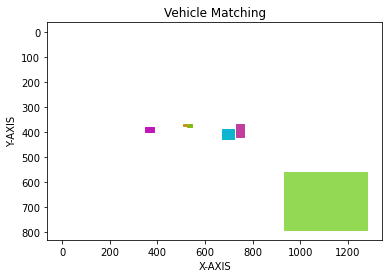

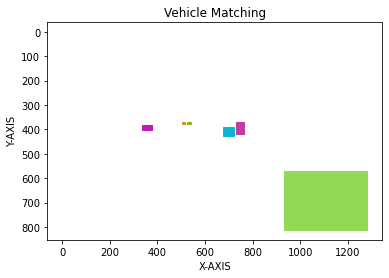

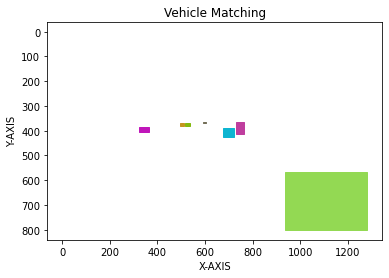

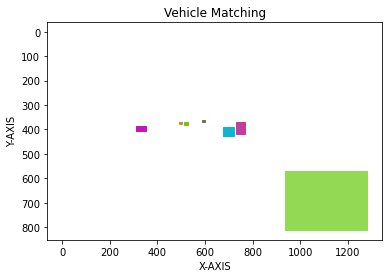

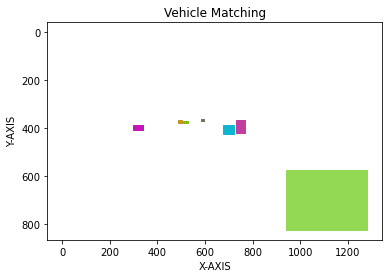

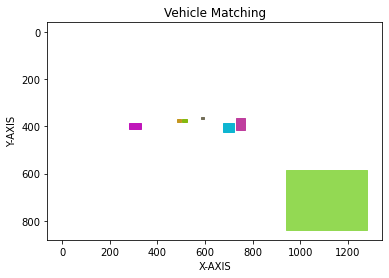

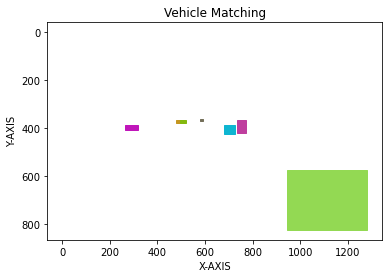

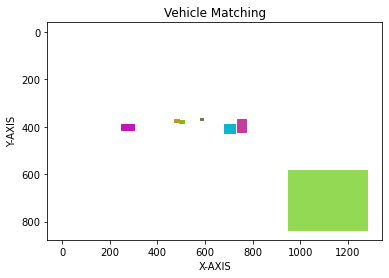

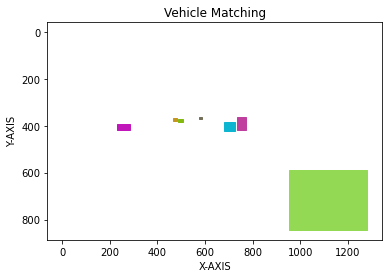

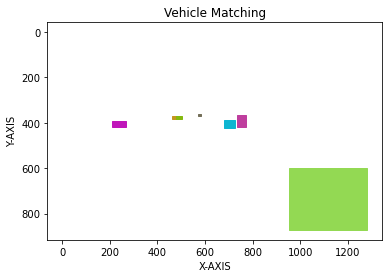

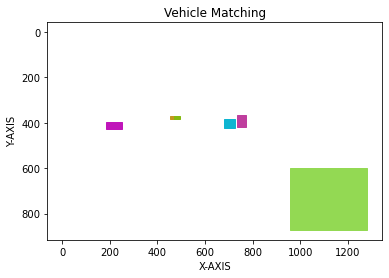

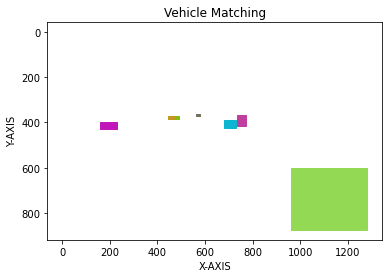

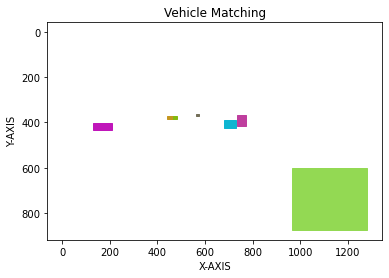

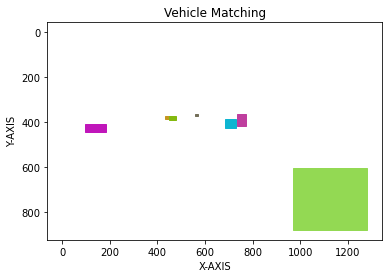

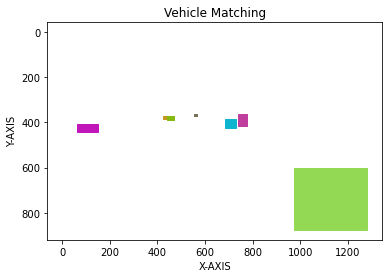

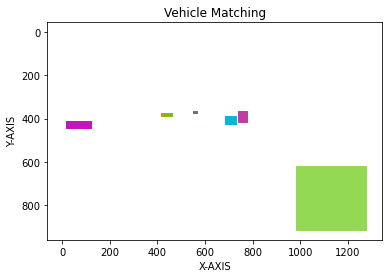

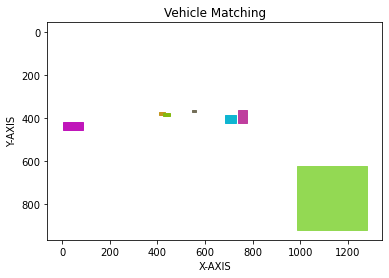

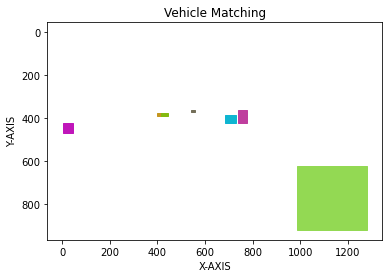

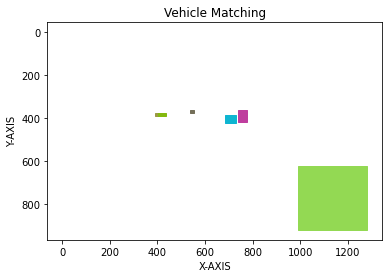

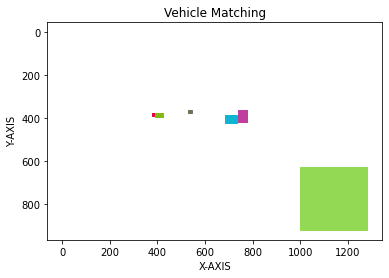

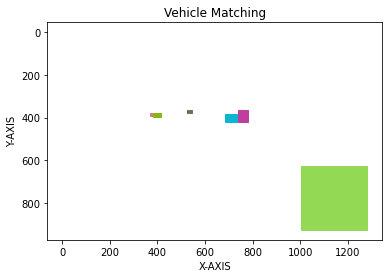

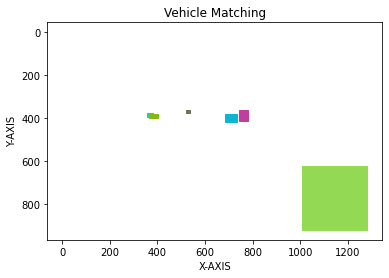

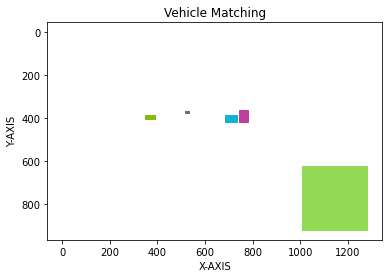

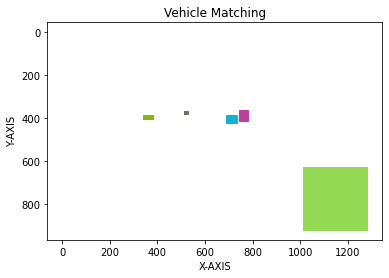

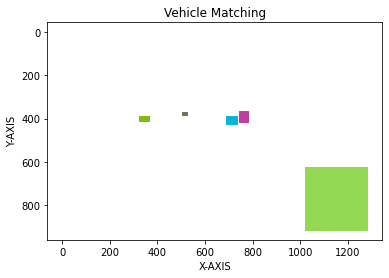

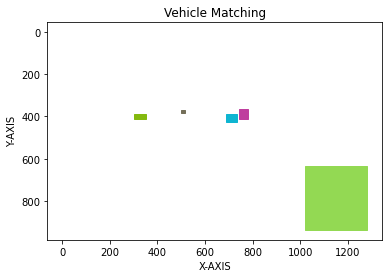

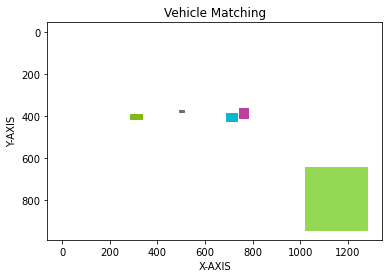

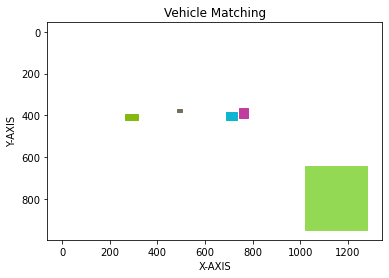

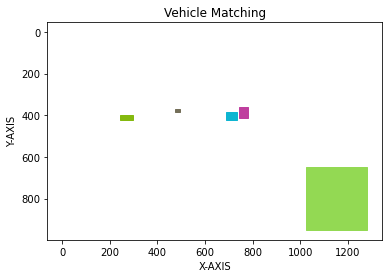

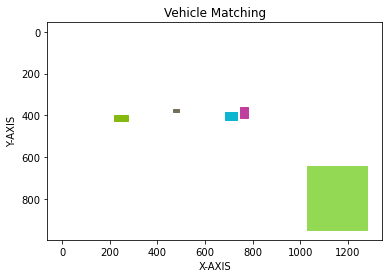

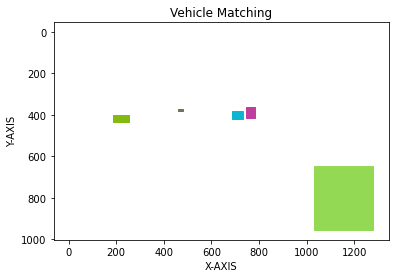

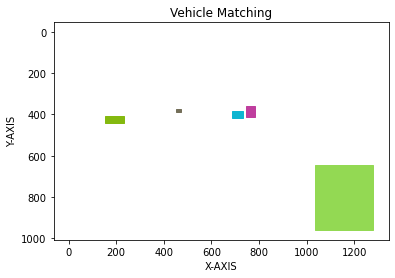

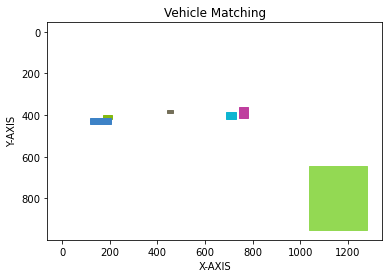

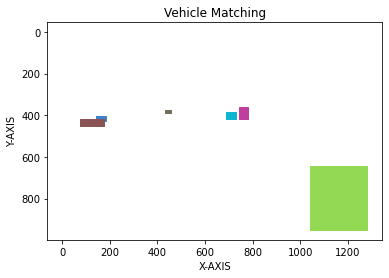

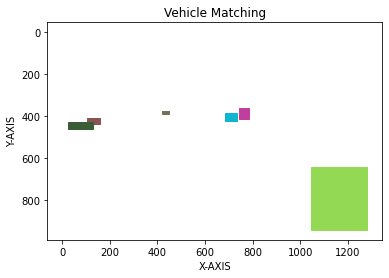

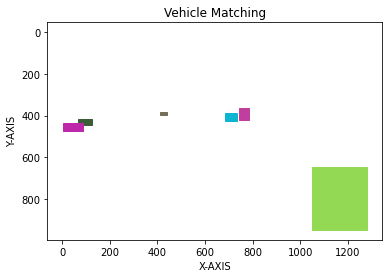

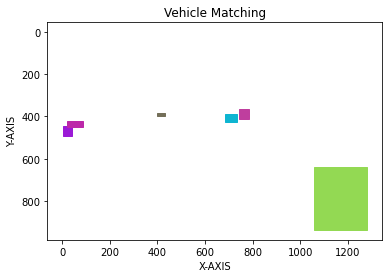

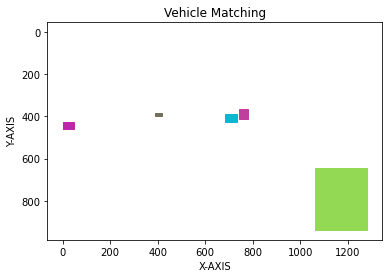

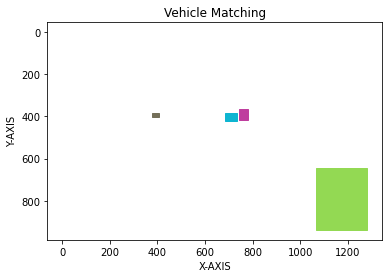

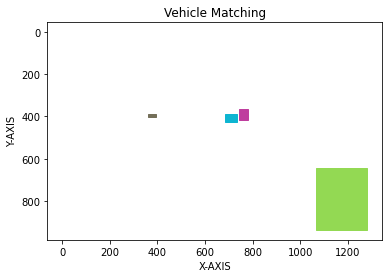

In [640]:
def saveShowMatchedImages(frameNo, bboxes, save):
    from matplotlib import pyplot as plt
    from matplotlib.patches import Rectangle
    i = 1
    for x in bboxes:
        fig, ax = plt.subplots()
        ax.plot([1,1280,2],[2,3,720],color="none")
        for bbox in bboxes[x]:
            a = bbox
            ax.add_patch(Rectangle((a['left'], a['bottom']), (a['right']-a['left']), (a['bottom']-a['top']),color=bbox["colour"]))
        ax.invert_yaxis()
        plt.xlabel("X-AXIS")
        plt.ylabel("Y-AXIS")
        plt.title(f"Vehicle Matching: Figure {frameNo}")
        if save:
            plt.savefig(f'save/{frameNo}-{i}.jpg')
        else:
            plt.show()
        i+=1

def boundingBoxDictToTuple(i):
    return (i["top"], i["right"], i["bottom"], i["left"])


from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
for x in xx:
    fig, ax = plt.subplots()
    ax.plot([1,1280,2],[2,3,720],color="none")
    for bbox in xx[x]:
        a = bbox
        ax.add_patch(Rectangle((a['left'], a['bottom']), (a['right']-a['left']), (a['bottom']-a['top']),color=bbox["colour"]))
    ax.invert_yaxis()
    plt.xlabel("X-AXIS")
    plt.ylabel("Y-AXIS")
    plt.title("Vehicle Matching")
    plt.show()


0.0


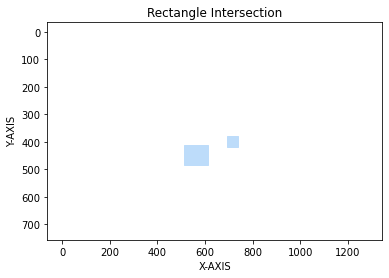

In [360]:
a = {'left': 690.0003200000001, 'top': 335.99977200000006, 'right': 740.0003200000001, 'bottom': 377.999748}
b = {'left': 510.00064, 'top': 335.9998800000001, 'right': 614.00064, 'bottom': 411.00012000000004}

print(iou(a,b))

fig, ax = plt.subplots()
ax.plot([1,1280,2],[2,3,720],color="none")
ax.add_patch(Rectangle((a['left'], a['bottom']), (a['right']-a['left']), (a['bottom']-a['top']),color=bbox["colour"]))
a = b
ax.add_patch(Rectangle((a['left'], a['bottom']), (a['right']-a['left']), (a['bottom']-a['top']),color=bbox["colour"]))
ax.invert_yaxis()
plt.xlabel("X-AXIS")
plt.ylabel("Y-AXIS")
plt.title("Rectangle Intersection")
plt.show()

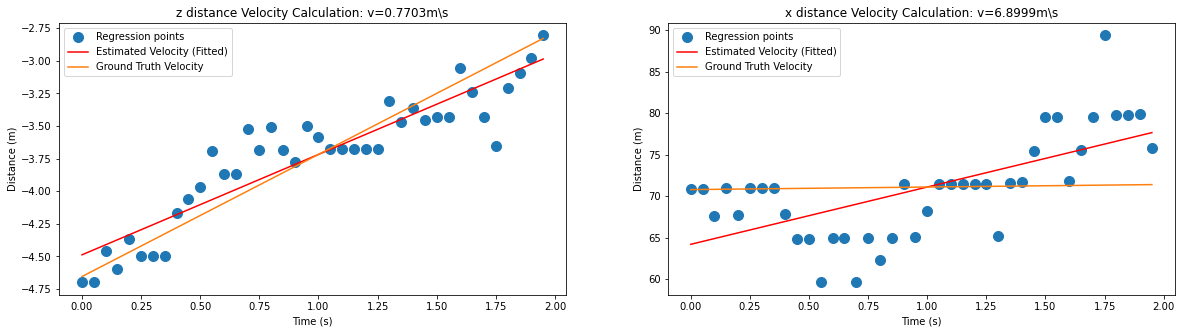

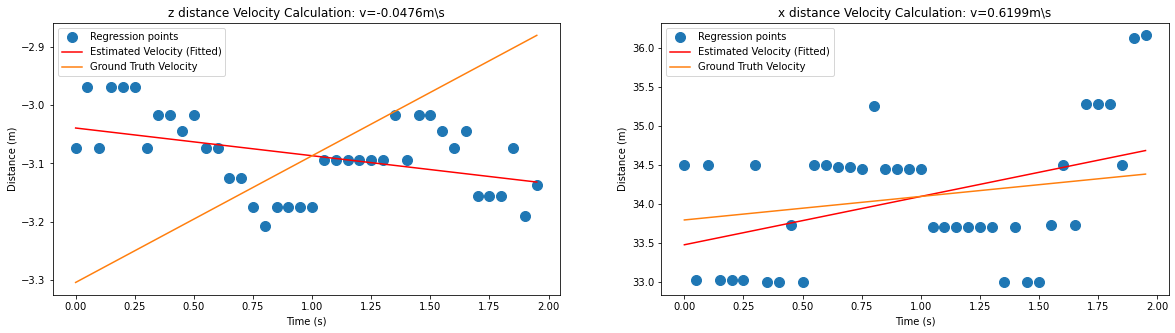

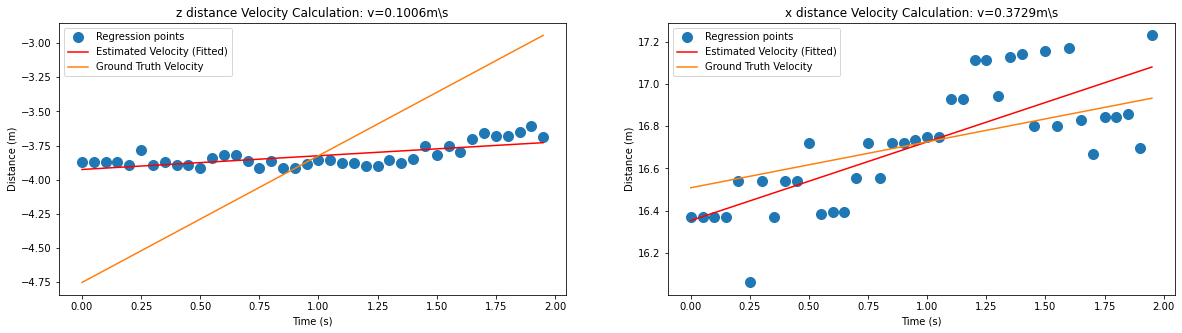

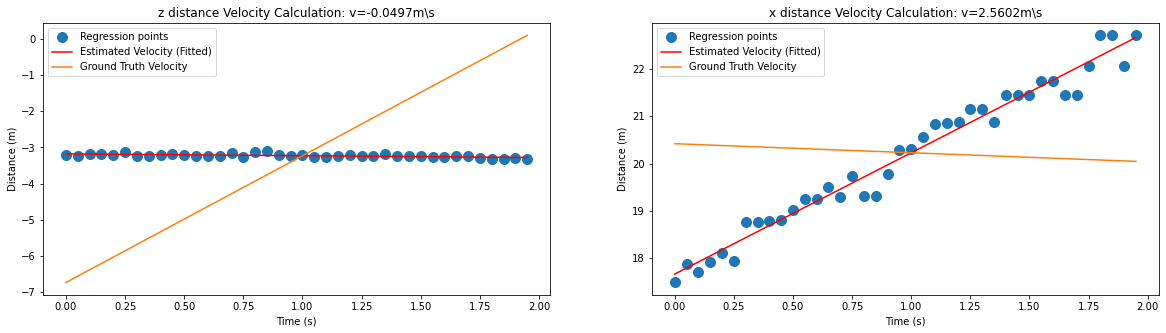

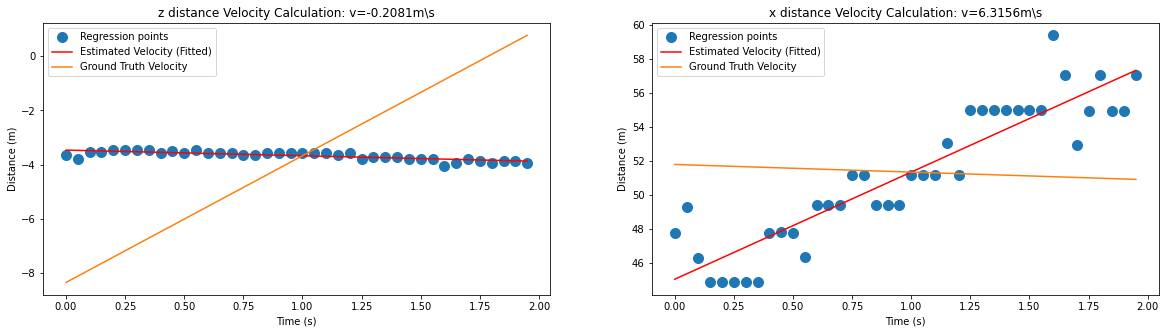

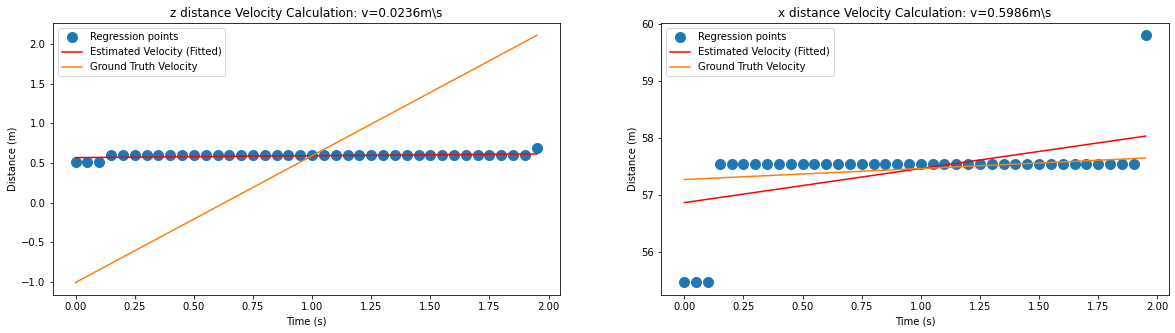

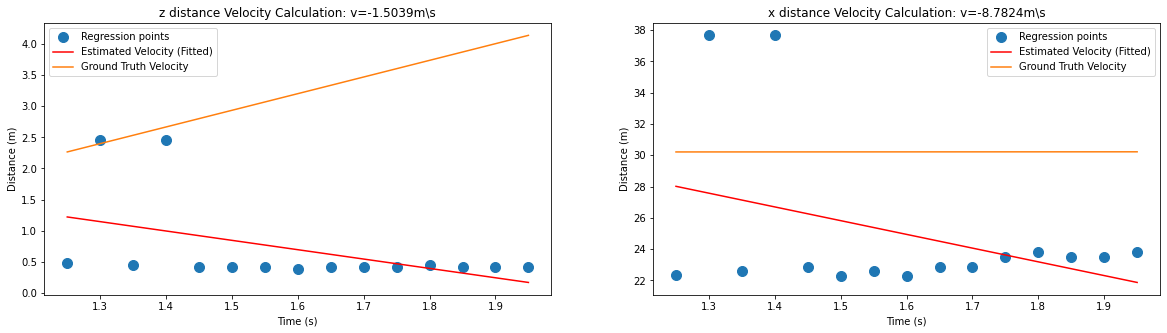

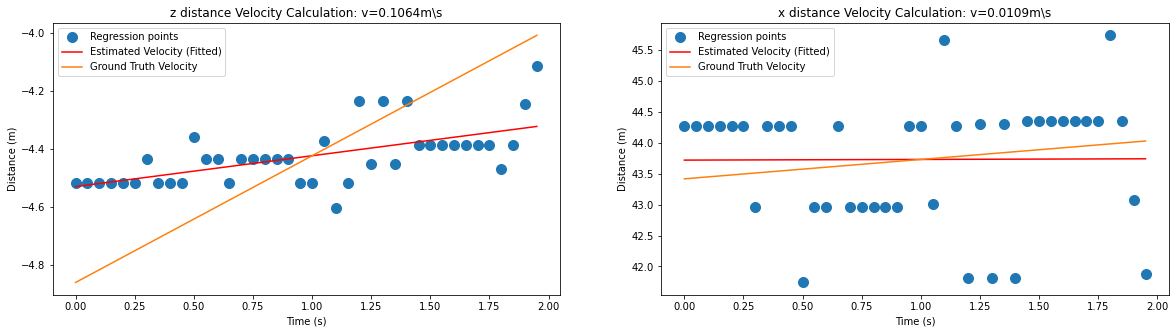

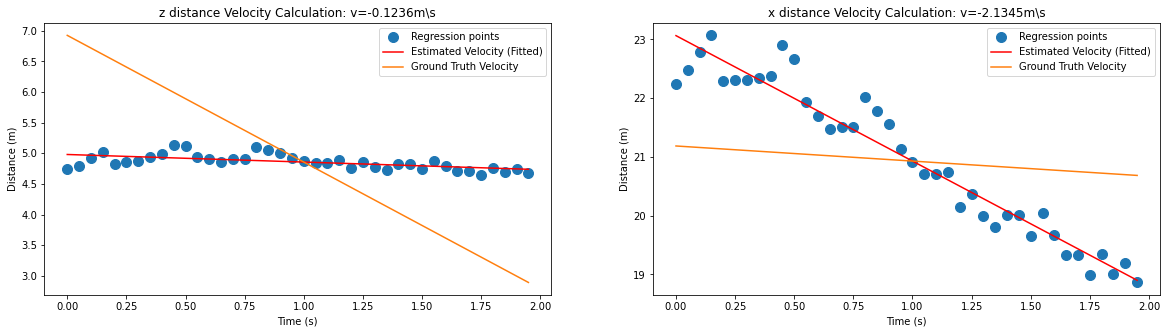

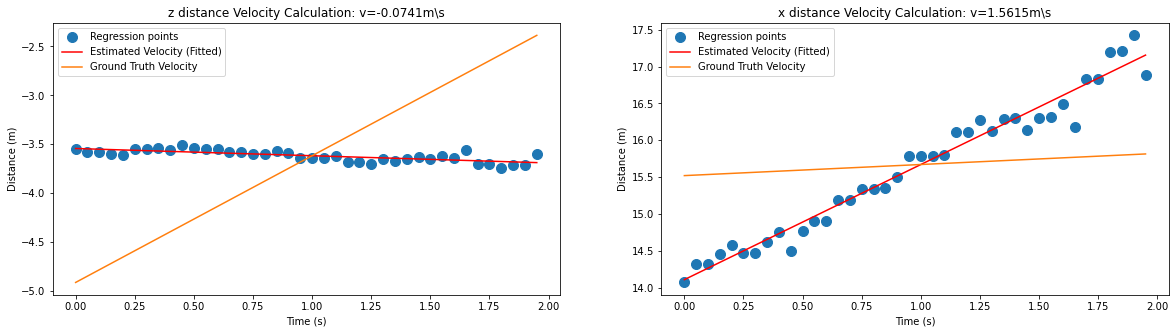

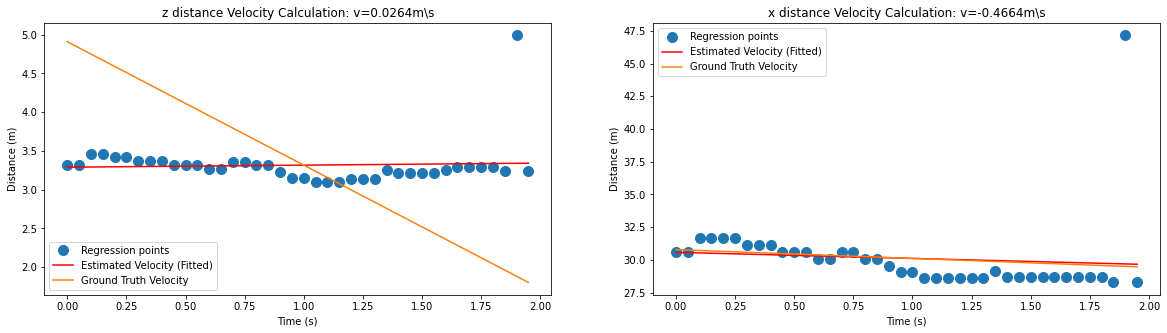

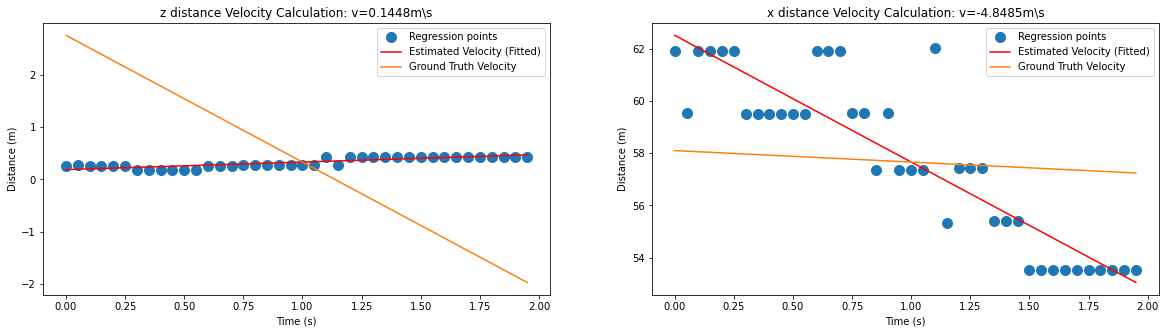

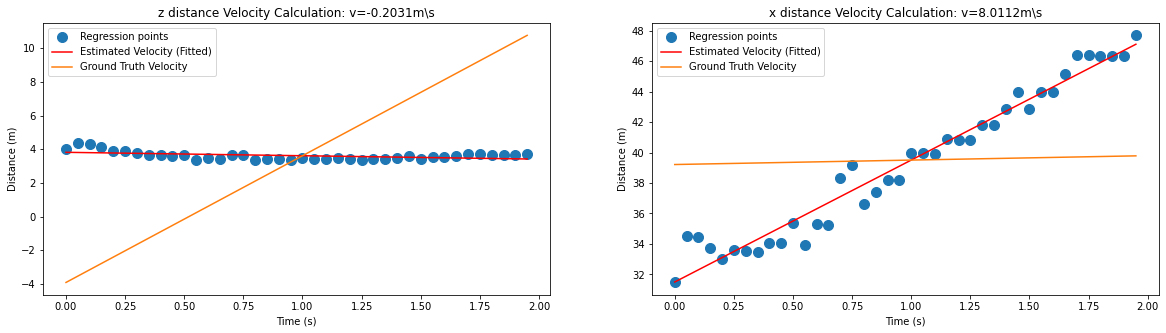

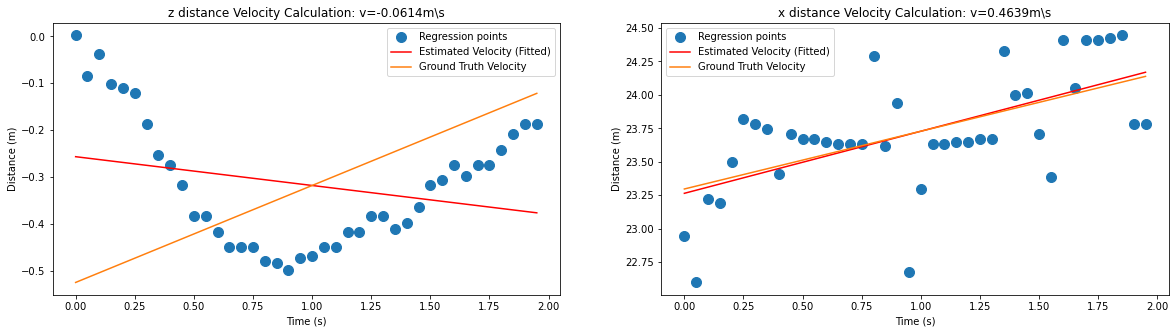

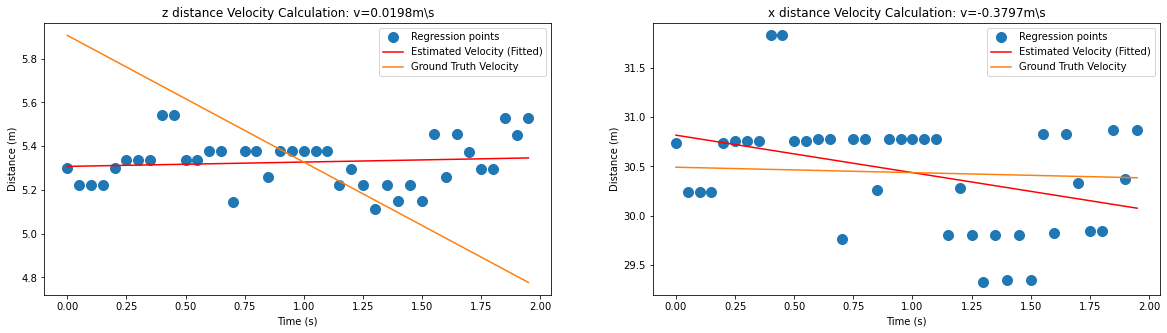

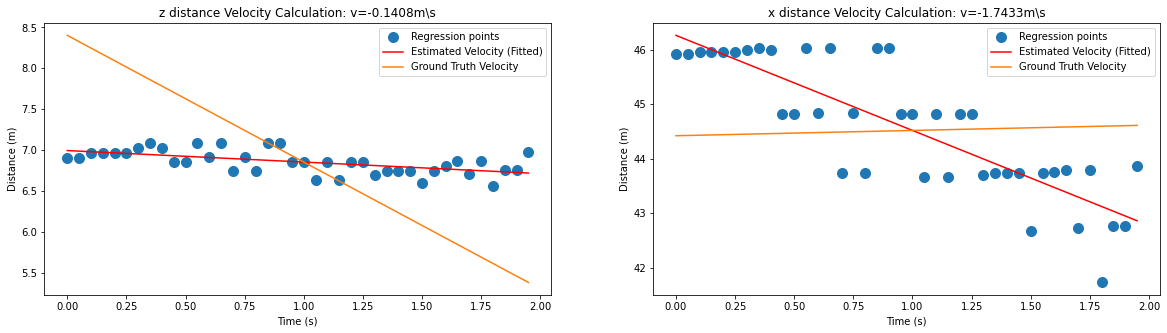

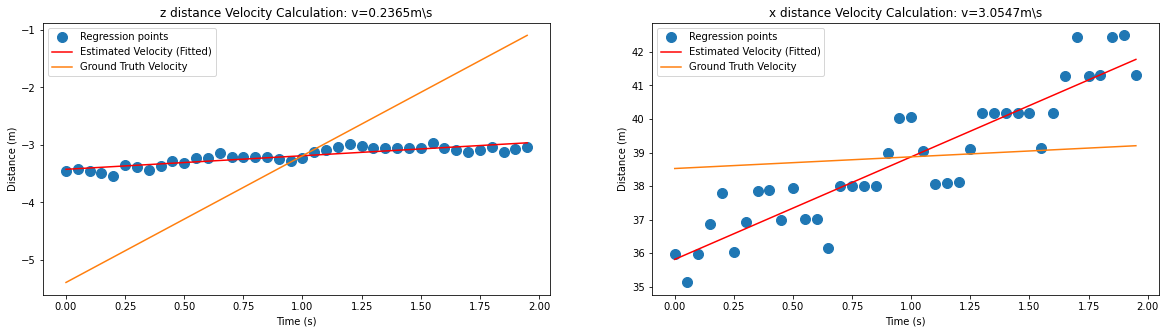

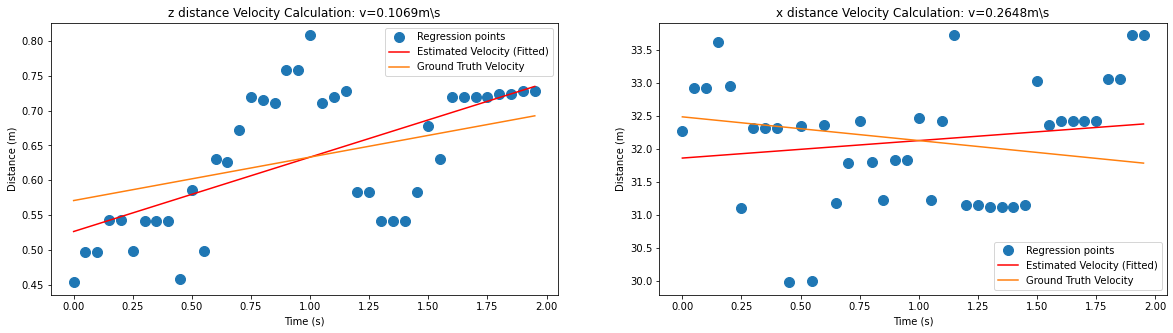

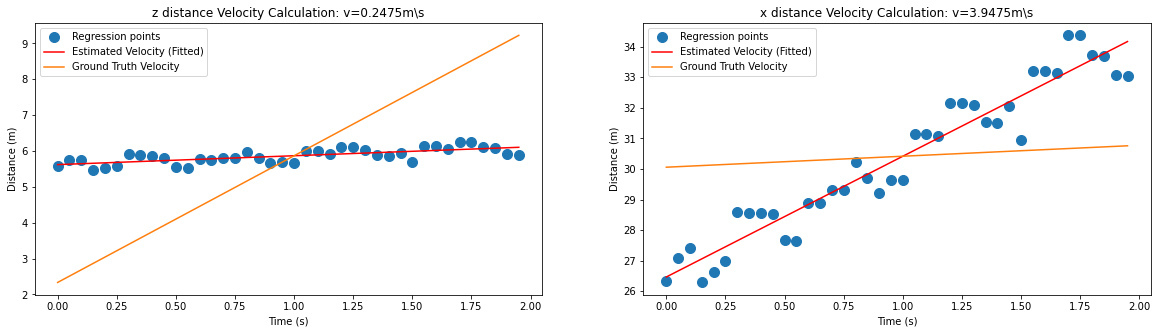

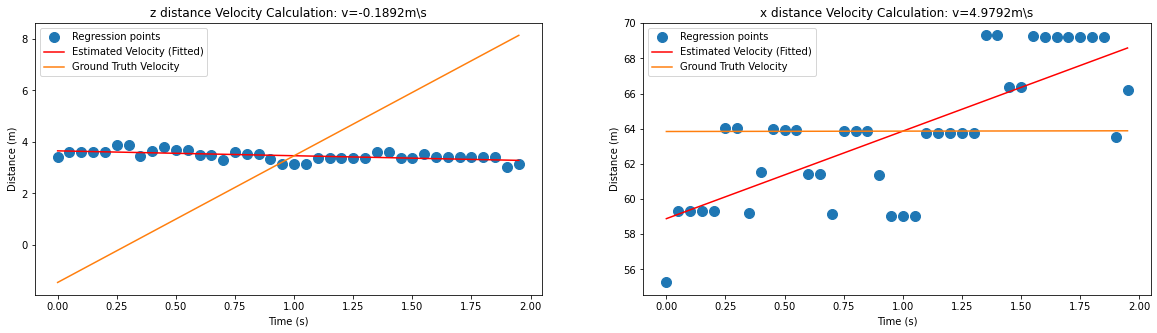

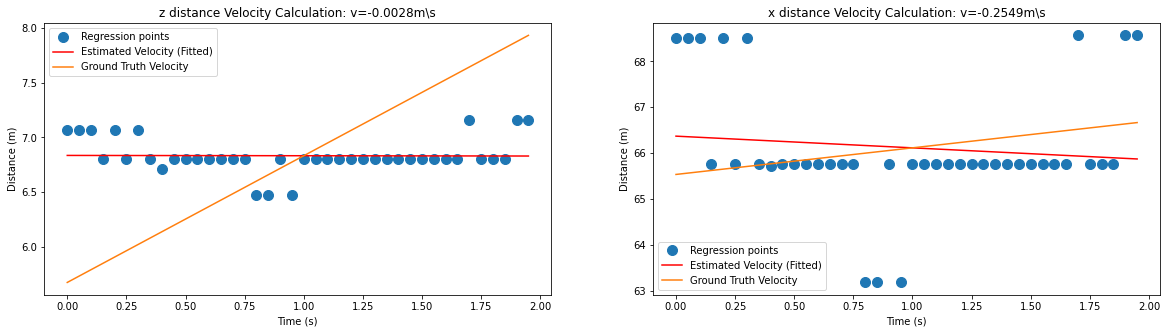

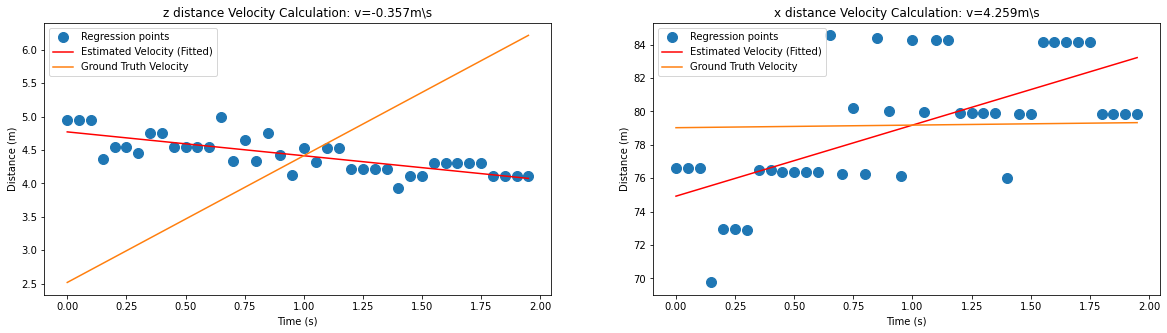

z Average Error 2.140853580858712
x Average Error 2.760115981164724
z Perc Average Error 98.88844370372728
x Perc Average Error 5223.970990602456


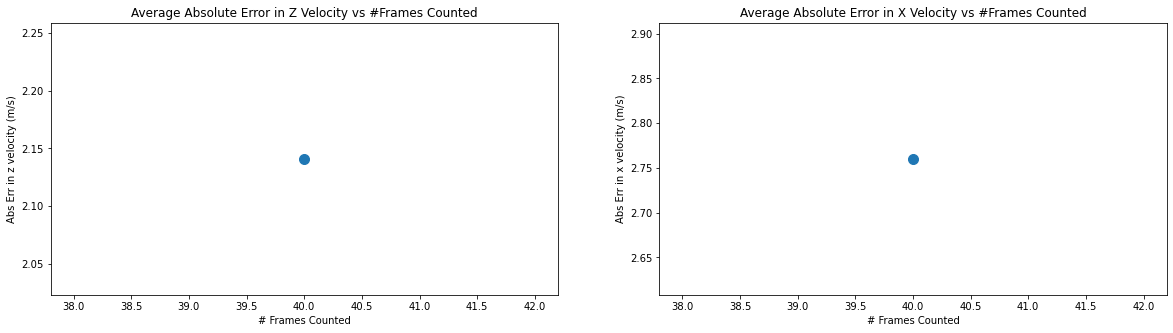

In [665]:
import os
import json

ifN = []
zAv = []
xAv = []

for interFrameN in range(40,41):
    ifN.append(interFrameN)
    count = 0
    zAverage = 0
    xAverage = 0

    zPercError = 0
    xPercError = 0


    for file in os.listdir("gtTrainBBoxesForDistance"):
        with open(os.path.join("gtTrainBBoxesForDistance", file)) as json_file:
            gt = json.load(json_file)
        with open(os.path.join("predTrainBBoxesForDistance", file)) as json_file:
            pred = json.load(json_file)

        prepareStructure(pred)
        matchBboxes(pred, 3, True)

#         saveShowMatchedImages(file[:-5], pred, False)

        velRedressionOutput = findVelocitiesRegression(pred,interFrameN, False)
        resultsMatch = matchGT(gt, velRedressionOutput, pred, True)


        for (predResZ, gtResZ), (predResX, gtResX)  in resultsMatch:
            zAverage += abs(gtResZ-predResZ)
            xAverage += abs(gtResX-predResX)

            zPercError += abs(100*(gtResZ-predResZ)/gtResZ)
            xPercError += abs(100*(gtResX-predResX)/gtResX)
            count+=1


    zAverage /= count
    xAverage /= count

    zPercError /= count
    xPercError /= count

    zAv.append(zAverage)
    xAv.append(xAverage)
    
    print("z Average Error", zAverage)
    print("x Average Error", xAverage)
    print("z Perc Average Error", zPercError)
    print("x Perc Average Error", xPercError)


plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(ifN, zAv, 'o-', markersize=10)
plt.title(f"Average Absolute Error in Z Velocity vs #Frames Counted")
plt.xlabel("# Frames Counted")
plt.ylabel("Abs Err in z velocity (m/s)")
plt.subplot(122)
plt.plot(ifN, xAv, 'o-', markersize=10)
plt.title(f"Average Absolute Error in X Velocity vs #Frames Counted")
plt.ylabel("Abs Err in x velocity (m/s)")
plt.xlabel("# Frames Counted")
plt.show()

    